Optimal k for LOOCV-Brute:  17
Optimal k for LOOCV-Efficient:  17
    Number of Neighbors k  LOOCV-Brute Score  LOOCV-Efficient Score
0                       1        7283.855204           13318.144796
1                       2        5513.629525            6633.815611
2                       3        4867.744847            5413.093514
3                       4        4711.142110            4799.068580
4                       5        4577.169140            4575.619548
5                       6        4418.749057            4486.572775
6                       7        4388.488688            4304.133946
7                       8        4289.751661            4299.157381
8                       9        4233.089772            4221.754483
9                      10        4186.943552            4200.215249
10                     11        4138.878539            4171.960996
11                     12        4135.658607            4174.689165
12                     13        4081.103349      

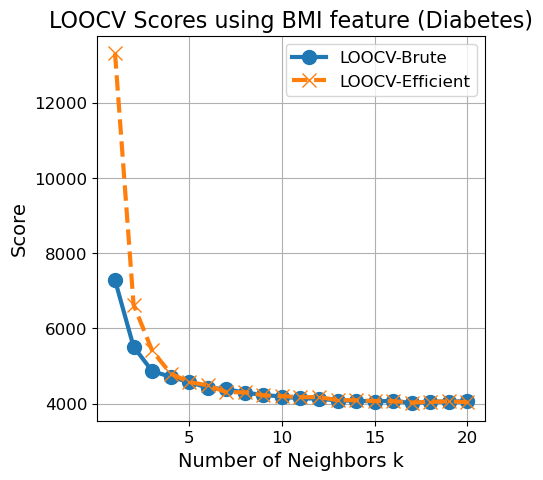

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

# Load diabetes dataset
data = load_diabetes()
X = data.data[:, np.newaxis, 2]  # Selecting only the BMI feature (third column)
y = data.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n = len(X_scaled)  # Sample size
max_k = int(np.sqrt(n))  # Maximum value for k based on the square root heuristic

# Test various numbers of neighbors, excluding the maximum k
k_range = range(1, max_k)
loo_scores_k = []
adjusted_scores_k = []

# Naive LOOCV score computation 
for k in k_range:
    scores_k = [] 
    for i in range(n):
        X_train = np.concatenate((X_scaled[:i], X_scaled[i+1:]))
        y_train = np.concatenate((y[:i], y[i+1:]))
        X_test = X_scaled[i:i+1]
        y_test = y[i:i+1]
        regressor_k = KNeighborsRegressor(n_neighbors=k, algorithm='kd_tree')
        regressor_k.fit(X_train, y_train)
        se_k = (y_test - regressor_k.predict(X_test)) ** 2
        scores_k.append(se_k.item())
    
    mse_k = np.mean(scores_k)
    loo_scores_k.append(mse_k)

# Efficient LOOCV score computation
for k in k_range:
    regressor_k_plus_1 = KNeighborsRegressor(n_neighbors=k+1, algorithm='kd_tree')
    regressor_k_plus_1.fit(X_scaled, y)
    y_pred_k_plus_1 = regressor_k_plus_1.predict(X_scaled)
    mse_k_plus_1 = (y - y_pred_k_plus_1) ** 2
    adjusted_score = np.mean(mse_k_plus_1) * ((k+1)**2 / k**2)
    adjusted_scores_k.append(adjusted_score)

# Create DataFrame for the results
results_df = pd.DataFrame({
    'Number of Neighbors k': list(k_range),
    'LOOCV-Brute Score': loo_scores_k,
    'LOOCV-Efficient Score': adjusted_scores_k  
})

# Find the optimal k for both methods
optimal_k_brute = k_range[np.argmin(loo_scores_k)]
optimal_k_efficient = k_range[np.argmin(adjusted_scores_k)]

# Display the results
print("Optimal k for LOOCV-Brute: ", optimal_k_brute)
print("Optimal k for LOOCV-Efficient: ", optimal_k_efficient)
print(results_df)

# Plot LOOCV-Brute and LOOCV-Efficient Scores
plt.figure(figsize=(5, 5))
plt.plot(list(k_range), loo_scores_k, marker='o', markersize=10, linewidth=3, label='LOOCV-Brute')
plt.plot(list(k_range), adjusted_scores_k, marker='x', markersize=10, linewidth=3, linestyle='--', label='LOOCV-Efficient')
plt.title('LOOCV Scores using BMI feature (Diabetes)', fontsize=16)
plt.xlabel('Number of Neighbors k', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()
